# Building a Retrieval-Augmented Generation (RAG) System

This notebook implements a Retrieval-Augmented Generation (RAG) system using:
- LangChain for document processing and vector operations
- FAISS for efficient similarity search
- Ollama for local LLM inference
- HuggingFace embeddings for text vectorization

We'll build a system that can answer questions about PDF documents by:
1. Loading and processing PDFs
2. Creating vector embeddings from the text
3. Performing similarity search for relevant content
4. Generating contextual answers using a local LLM

## 1. Setup Environment and Import Libraries

First, we need to install the required packages:

In [1]:
# # Install required packages
# %pip install langchain faiss-cpu pypdf2 ollama sentence-transformers

In [2]:
# %pip install -U langchain-community

In [3]:
# %pip install ipywidgets matplotlib

Now, let's import all the necessary libraries:

In [4]:
# Import necessary libraries
import os
import ollama
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from IPython.display import Markdown, display
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
import time

## 2. PDF Loading and Text Extraction

We'll create a function to load PDF files and extract text from them:

In [5]:
def load_pdf(file_path):
    """
    Load a PDF file and extract text from it.
    
    Args:
        file_path (str): Path to the PDF file
        
    Returns:
        str: Extracted text from the PDF
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")
    
    with open(file_path, "rb") as file:
        reader = PdfReader(file)
        text = ""
        num_pages = len(reader.pages)
        
        print(f"Processing {num_pages} pages...")
        
        for i, page in enumerate(reader.pages):
            page_text = page.extract_text()
            text += page_text + "\n"
            # Print progress
            if (i+1) % 5 == 0 or i+1 == num_pages:
                print(f"Processed {i+1}/{num_pages} pages")
                
    print(f"Extracted {len(text)} characters of text.")
    return text

In [6]:
# Add after the load_pdf function

def load_pdfs_from_directory(directory_path):
    """
    Load all PDF files from a directory.
    
    Args:
        directory_path (str): Path to the directory containing PDFs
        
    Returns:
        list: List of tuples (filename, text_content)
    """
    import glob
    
    if not os.path.exists(directory_path):
        raise FileNotFoundError(f"The directory {directory_path} does not exist.")
    
    pdf_files = glob.glob(os.path.join(directory_path, "*.pdf"))
    
    if not pdf_files:
        print(f"No PDF files found in {directory_path}")
        return []
    
    print(f"Found {len(pdf_files)} PDF files in {directory_path}")
    
    all_documents = []
    
    for pdf_file in pdf_files:
        try:
            print(f"\nProcessing: {os.path.basename(pdf_file)}")
            pdf_text = load_pdf(pdf_file)
            all_documents.append((os.path.basename(pdf_file), pdf_text))
            print(f"Successfully loaded {os.path.basename(pdf_file)}")
        except Exception as e:
            print(f"Error loading {pdf_file}: {str(e)}")
    
    return all_documents

Let's test our PDF loading function with a sample PDF. For this example, we'll use the annual report PDF mentioned in the original code:

In [7]:
# Replace the PDF loading cell with this

# Path to the directory containing PDFs
reports_directory = "../Reports"

try:
    # Load all PDFs from the directory
    documents = load_pdfs_from_directory(reports_directory)
    
    if documents:
        print(f"\nSuccessfully loaded {len(documents)} documents")
        
        # Display summary of loaded documents
        total_text_length = sum(len(text) for _, text in documents)
        print(f"Total text length across all documents: {total_text_length} characters")
        
        for filename, text in documents[:3]:  # Show details for first 3 documents
            print(f"\n{filename}: {len(text)} characters")
            print("Sample text (first 200 characters):")
            print("-" * 50)
            print(text[:200] + "...")
            print("-" * 50)
            
        if len(documents) > 3:
            print(f"... and {len(documents) - 3} more document(s)")
    else:
        print("No documents were loaded. Using sample text for demonstration.")
        # Create a placeholder for demonstration purposes
        documents = [("sample.pdf", "This is a sample text that simulates content from a PDF file. " * 100)]
        
except Exception as e:
    print(f"Error: {str(e)}")
    # Create a placeholder for demonstration purposes
    documents = [("sample.pdf", "This is a sample text that simulates content from a PDF file. " * 100)]

Found 5 PDF files in ../Reports

Processing: infosys-ar-20.pdf
Processing 313 pages...
Processed 5/313 pages
Processed 10/313 pages
Processed 15/313 pages
Processed 20/313 pages
Processed 25/313 pages
Processed 30/313 pages
Processed 35/313 pages
Processed 40/313 pages
Processed 45/313 pages
Processed 50/313 pages
Processed 55/313 pages
Processed 60/313 pages
Processed 65/313 pages
Processed 70/313 pages
Processed 75/313 pages
Processed 80/313 pages
Processed 85/313 pages
Processed 90/313 pages
Processed 95/313 pages
Processed 100/313 pages
Processed 105/313 pages
Processed 110/313 pages
Processed 115/313 pages
Processed 120/313 pages
Processed 125/313 pages
Processed 130/313 pages
Processed 135/313 pages
Processed 140/313 pages
Processed 145/313 pages
Processed 150/313 pages
Processed 155/313 pages
Processed 160/313 pages
Processed 165/313 pages
Processed 170/313 pages
Processed 175/313 pages
Processed 180/313 pages
Processed 185/313 pages
Processed 190/313 pages
Processed 195/313 pag

## 3. Text Chunking and Vector Store Creation

For effective retrieval, we need to split the text into manageable chunks and create embeddings:

In [8]:
# Replace the create_vector_store function with this version

def create_vector_store(documents, chunk_size=1000, chunk_overlap=200):
    """
    Split text into chunks and create a vector store with metadata.
    
    Args:
        documents (list): List of (filename, text) tuples
        chunk_size (int): Size of each chunk
        chunk_overlap (int): Overlap between chunks
        
    Returns:
        FAISS: Vector store object
    """
    # Split text into chunks
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len
    )
    
    start_time = time.time()
    all_chunks = []
    all_metadatas = []
    
    for filename, text in documents:
        chunks = text_splitter.split_text(text)
        metadatas = [{"source": filename} for _ in range(len(chunks))]
        
        all_chunks.extend(chunks)
        all_metadatas.extend(metadatas)
    
    chunking_time = time.time() - start_time
    
    print(f"Split text into {len(all_chunks)} chunks across {len(documents)} documents (took {chunking_time:.2f} seconds)")
    
    # Create embeddings
    print("Initializing embedding model...")
    embeddings = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-MiniLM-L6-v2"
    )
    
    # Create vector store
    print("Creating vector store...")
    start_time = time.time()
    vector_store = FAISS.from_texts(all_chunks, embeddings, metadatas=all_metadatas)
    vectorization_time = time.time() - start_time
    
    print(f"Vector store created with {len(all_chunks)} vectors (took {vectorization_time:.2f} seconds)")
    
    return vector_store, all_chunks

Split text into 7545 chunks across 5 documents (took 0.12 seconds)
Initializing embedding model...


/tmp/ipykernel_2349815/475983215.py:39: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


Creating vector store...
Vector store created with 7545 vectors (took 7.12 seconds)


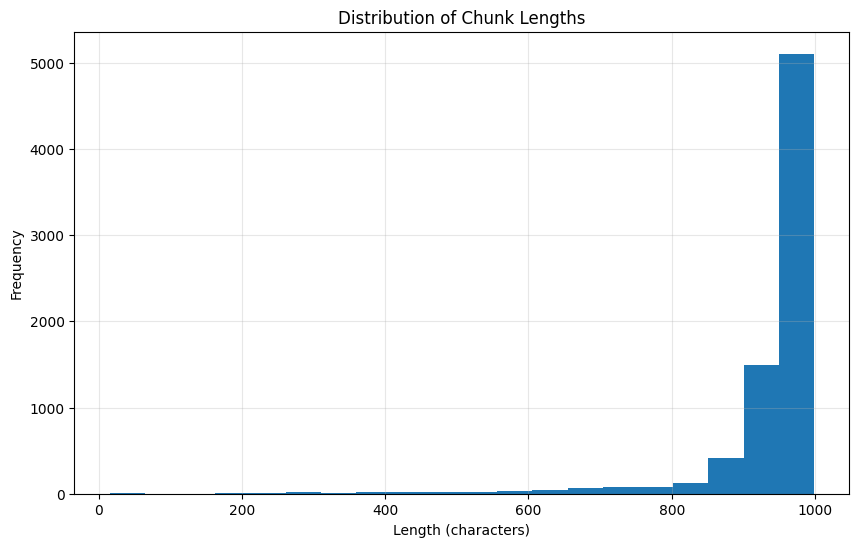

Average chunk length: 939.4 characters
Shortest chunk: 15 characters
Longest chunk: 999 characters


In [9]:
# Replace the vector store creation cell with this

# Create vector store from all documents
vector_store, chunks = create_vector_store(documents)

# Display some statistics about the chunks
chunk_lengths = [len(chunk) for chunk in chunks]

plt.figure(figsize=(10, 6))
plt.hist(chunk_lengths, bins=20)
plt.title('Distribution of Chunk Lengths')
plt.xlabel('Length (characters)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Average chunk length: {np.mean(chunk_lengths):.1f} characters")
print(f"Shortest chunk: {min(chunk_lengths)} characters")
print(f"Longest chunk: {max(chunk_lengths)} characters")

Let's examine a few chunks to understand what our text looks like after chunking:

In [10]:
# with open("chunk_preview.txt", "w", encoding="utf-8") as f:
#     for chunk in chunks[:3]:
#         f.write(chunk[:100] + "...\n\n")


In [11]:
# # Display a few example chunks
# for i in range(min(3, len(chunks))):
#     print(f"Chunk {i+1} ({len(chunks[i])} characters):")
#     print("-" * 50)
#     print(chunks[i][:300] + "...")  # Show first 300 chars
#     print("-" * 50)

## 4. Question Answering with Ollama

Now, let's implement the question answering functionality using the Ollama API with the deepseek-r1 model:

In [12]:
def ask_ollama(query, context):
    """
    Generate an answer using Ollama API based on the provided context.
    
    Args:
        query (str): The user's question
        context (str): Context information retrieved from the vector store
        
    Returns:
        str: Generated answer from the model
    """
    prompt = f"""
    Answer the question based on the following context:

    Context:
    {context}

    Question: {query}
    
    Answer:
    """
    
    try:
        response = ollama.chat(
            model="deepseek-r1",
            messages=[{"role": "user", "content": prompt}]
        )
        
        return response['message']['content']
    except Exception as e:
        return f"Error generating response: {str(e)}"

In [13]:
# Update the answer_question function to show source information

def answer_question(query, vector_store, k=4):
    """
    Answer a question using RAG approach.
    
    Args:
        query (str): User's question
        vector_store: FAISS vector store
        k (int): Number of relevant chunks to retrieve
        
    Returns:
        str: Answer to the question
    """
    print(f"Searching for context relevant to: '{query}'")
    
    # Retrieve relevant chunks
    start_time = time.time()
    docs = vector_store.similarity_search(query, k=k)
    search_time = time.time() - start_time
    
    print(f"Retrieved {len(docs)} relevant chunks (took {search_time:.2f} seconds)")
    
    # Format context with source information
    context_parts = []
    for doc in docs:
        source = doc.metadata.get('source', 'Unknown')
        context_parts.append(f"Source: {source}\n{doc.page_content}")
    
    context = "\n\n---\n\n".join(context_parts)
    context_length = len(context)
    
    print(f"Sending prompt with context of {context_length} characters to Ollama...")
    
    # Get answer from Ollama
    start_time = time.time()
    answer = ask_ollama(query, context)
    generation_time = time.time() - start_time
    
    print(f"Generated answer of {len(answer)} characters (took {generation_time:.2f} seconds)")
    
    return answer, docs

Let's test our question answering function with a sample question:

In [14]:
# Test with a sample question
sample_question = "What are the main financial highlights?"
answer, relevant_docs = answer_question(sample_question, vector_store)

print("\nQuestion:", sample_question)
print("\nAnswer:")
print("-" * 80)
print(answer)
print("-" * 80)

print("\nTop relevant context used:")
for i, doc in enumerate(relevant_docs[:2]):  # Show only first 2 contexts
    print(f"\nContext chunk {i+1}:")
    print("..." + doc.page_content[:300] + "...")  # First 300 chars

Searching for context relevant to: 'What are the main financial highlights?'
Retrieved 4 relevant chunks (took 0.03 seconds)
Sending prompt with context of 4033 characters to Ollama...
Generated answer of 4201 characters (took 12.54 seconds)

Question: What are the main financial highlights?

Answer:
--------------------------------------------------------------------------------
<think>
Okay, so I need to figure out the main financial highlights from the provided context. Let me start by reading through each source carefully and noting down the key points.

First, looking at infosys-ar-23.pdf, there's a section titled "Consolidated Cash and Investments." It mentions that cash and investments include various instruments with high credit ratings. There's also a part about investments in startups which help access innovation for client benefits. However, this seems more like an overview rather than specific financial highlights.

Next, another part of infosys-ar-23.pdf details the consol

## 5. Interactive Demo

Let's create an interactive demo using IPython widgets:

In [15]:
def create_interactive_demo(vector_store):
    """Create an interactive demo for question answering"""
    
    # Create widgets
    question_input = widgets.Text(
        value='',
        description='Question:',
        placeholder='Type your question here...',
        layout=widgets.Layout(width='80%')
    )
    
    k_slider = widgets.IntSlider(
        value=4,
        min=1,
        max=10,
        step=1,
        description='Context chunks:',
        layout=widgets.Layout(width='50%')
    )
    
    output = widgets.Output()
    
    # Submit button
    button = widgets.Button(
        description='Get Answer',
        button_style='primary',
        tooltip='Click to get the answer',
        icon='search'
    )
    
    def on_button_clicked(_):
        with output:
            output.clear_output()
            if question_input.value.strip():
                print(f"Question: {question_input.value}")
                print("Generating answer...")
                answer, docs = answer_question(question_input.value, vector_store, k=k_slider.value)
                display(Markdown("### Answer:"))
                display(Markdown(answer))
                
                display(Markdown("### Sources:"))
                for i, doc in enumerate(docs):
                    display(Markdown(f"**Source {i+1}** (extract):\n> {doc.page_content[:150]}..."))
            else:
                print("Please enter a question.")
    
    button.on_click(on_button_clicked)
    
    # Layout
    return widgets.VBox([
        widgets.HTML("<h3>RAG Question Answering System</h3>"),
        widgets.HBox([question_input, button]),
        k_slider,
        output
    ])

In [16]:
# Create and display the interactive demo
demo = create_interactive_demo(vector_store)
display(demo)

## 6. Error Handling and Improvements

Let's enhance our system with better error handling and explore potential improvements:

In [17]:
class RAGSystem:
    """A more robust implementation of our RAG system with error handling"""
    
    def __init__(self, model_name="deepseek-r1", 
                 embeddings_model="sentence-transformers/all-MiniLM-L6-v2",
                 chunk_size=1000, chunk_overlap=200):
        self.model_name = model_name
        self.embeddings_model_name = embeddings_model
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap
        self.vector_store = None
        self.chunks = []
        self.pdf_text = ""
        
    def load_document(self, file_path):
        """Load document and handle errors"""
        try:
            if file_path.lower().endswith('.pdf'):
                self.pdf_text = load_pdf(file_path)
                return True, f"Successfully loaded PDF with {len(self.pdf_text)} characters"
            else:
                return False, "Only PDF files are currently supported"
        except FileNotFoundError:
            return False, f"File not found: {file_path}"
        except Exception as e:
            return False, f"Error loading document: {str(e)}"
    
    def process_document(self):
        """Process the loaded document and create vector store"""
        try:
            if not self.pdf_text:
                return False, "No document loaded. Please load a document first."
            
            self.vector_store, self.chunks = create_vector_store(
                self.pdf_text, self.chunk_size, self.chunk_overlap
            )
            return True, f"Successfully processed document into {len(self.chunks)} chunks"
        except Exception as e:
            return False, f"Error processing document: {str(e)}"
    
    def answer_query(self, query, k=4):
        """Answer a query with improved error handling"""
        try:
            if not self.vector_store:
                return False, "Vector store not initialized. Process a document first."
            
            if not query.strip():
                return False, "Query cannot be empty"
            
            answer, docs = answer_question(query, self.vector_store, k)
            return True, {"answer": answer, "sources": docs}
        except Exception as e:
            return False, f"Error answering query: {str(e)}"
    
    def suggest_improvements(self):
        """Suggest possible improvements to the RAG system"""
        improvements = [
            "**Implement document metadata** - Track source information for each chunk",
            "**Add document pre-processing** - Clean and normalize text before chunking",
            "**Experiment with different embedding models** - Try models like E5, BGE, or INSTRUCTOR",
            "**Implement re-ranking** - Use a cross-encoder to re-rank the retrieved chunks",
            "**Add chat history** - Maintain conversation context for follow-up questions",
            "**Optimize chunking strategy** - Try semantic chunking instead of character-based",
            "**Implement hybrid search** - Combine vector search with keyword-based search",
            "**Add evaluation metrics** - Measure relevance and answer quality"
        ]
        return improvements

In [18]:
# Create and test our improved RAG system
rag = RAGSystem()

# Show potential improvements
print("Potential improvements for the RAG system:")
for i, improvement in enumerate(rag.suggest_improvements(), 1):
    print(f"{i}. {improvement}")

Potential improvements for the RAG system:
1. **Implement document metadata** - Track source information for each chunk
2. **Add document pre-processing** - Clean and normalize text before chunking
3. **Experiment with different embedding models** - Try models like E5, BGE, or INSTRUCTOR
4. **Implement re-ranking** - Use a cross-encoder to re-rank the retrieved chunks
5. **Add chat history** - Maintain conversation context for follow-up questions
6. **Optimize chunking strategy** - Try semantic chunking instead of character-based
7. **Implement hybrid search** - Combine vector search with keyword-based search
8. **Add evaluation metrics** - Measure relevance and answer quality


### Summary and Conclusion

In this notebook, we've built a complete Retrieval-Augmented Generation (RAG) system that:

1. Loads and processes PDF documents
2. Chunks text and creates vector embeddings
3. Performs similarity search to find relevant context
4. Uses Ollama with the deepseek-r1 model to generate answers
5. Provides an interactive interface for querying the document

This implementation demonstrates the core components of a RAG system, but there are many ways to improve it further, as outlined in the improvements section.

Key takeaways:
- RAG enhances LLM responses with relevant context from specific documents
- The quality of chunking and embeddings directly impacts retrieval performance
- Local models like those in Ollama provide privacy and control advantages
- Error handling is crucial for production-ready RAG systems

# ---

## 7. News Agent - Financial News Analysis

Now let's implement a News Agent that fetches and analyzes news articles about companies. The News Agent will:
1. Fetch recent news articles using the News API
2. Extract relevant information from the articles
3. Analyze sentiment and key points
4. Integrate this information with our existing RAG system

In [19]:
# Install required packages for News Agent
# %pip install newsapi-python requests

In [20]:
import requests
import os
from datetime import datetime, timedelta
from typing import List, Dict, Any, Optional
import json

class NewsAgent:
    """Agent for fetching and analyzing financial news"""
    
    def __init__(self, api_key=None):
        """Initialize the News Agent with API key"""
        self.api_key = api_key or os.environ.get("NEWS_API_KEY")
        if not self.api_key:
            print("Warning: No News API key provided. You'll need to set your API key.")
            print("Get a free API key from https://newsapi.org/")
            print("Then set it with: news_agent.set_api_key('your_api_key')")
        self.base_url = "https://newsapi.org/v2"
        
    def set_api_key(self, api_key: str) -> None:
        """Set the News API key"""
        self.api_key = api_key
        print("API key set successfully!")
        
    def get_company_news(self, company_name: str, days: int = 7, 
                        max_results: int = 10) -> List[Dict[str, Any]]:
        """Fetch news about a specific company"""
        if not self.api_key:
            return [{
                "title": "Error: No API key provided",
                "description": "Please set your News API key first",
                "content": "To use the News Agent, you need to set your API key."
            }]
        
        # Calculate date range
        end_date = datetime.now().strftime("%Y-%m-%d")
        start_date = (datetime.now() - timedelta(days=days)).strftime("%Y-%m-%d")
        
        # Prepare request
        endpoint = f"{self.base_url}/everything"
        params = {
            "q": company_name,
            "from": start_date,
            "to": end_date,
            "sortBy": "relevancy",
            "language": "en",
            "pageSize": max_results,
            "apiKey": self.api_key
        }
        
        try:
            response = requests.get(endpoint, params=params)
            response.raise_for_status()
            data = response.json()
            
            if data.get("status") == "ok":
                articles = data.get("articles", [])
                return [{
                    "title": article.get("title"),
                    "source": article.get("source", {}).get("name"),
                    "author": article.get("author"),
                    "published_at": article.get("publishedAt"),
                    "description": article.get("description"),
                    "content": article.get("content"),
                    "url": article.get("url")
                } for article in articles]
            else:
                print(f"API Error: {data.get('message')}")
                return []
        except Exception as e:
            print(f"Error fetching news: {e}")
            return []
    
    def get_industry_news(self, industry: str, days: int = 7, 
                         max_results: int = 10) -> List[Dict[str, Any]]:
        """Fetch news about a specific industry"""
        return self.get_company_news(f"{industry} industry", days, max_results)
    
    def analyze_sentiment(self, articles: List[Dict[str, Any]], 
                         llm_model: str = "deepseek-r1") -> Dict[str, Any]:
        """Analyze sentiment and key points from articles using Ollama"""
        if not articles:
            return {"error": "No articles to analyze"}
        
        # Prepare articles text for analysis
        articles_text = "\n\n".join([f"Title: {a['title']}\n" + 
                                    f"Source: {a['source']}\n" +
                                    f"Date: {a['published_at']}\n" +
                                    f"Description: {a['description']}\n" + 
                                    f"Content: {a['content']}" 
                                   for a in articles[:5]])
        
        # Prepare prompt for Ollama
        prompt = f"""
        Analyze the following news articles and provide:
        1. Overall sentiment (positive, neutral, or negative)
        2. Key points or trends mentioned
        3. Any significant events or announcements
        4. Potential financial implications
        
        Articles:
        {articles_text}
        
        Your analysis should be concise and focus on financial relevance.
        """
        
        try:
            response = ollama.chat(
                model=llm_model,
                messages=[{"role": "user", "content": prompt}]
            )
            
            analysis = response['message']['content']
            
            return {
                "analysis": analysis,
                "articles_analyzed": len(articles[:5]),
                "total_articles": len(articles)
            }
        except Exception as e:
            print(f"Error analyzing articles: {e}")
            return {"error": f"Analysis failed: {str(e)}"}
    
    def summarize_news(self, company_name: str, days: int = 7) -> Dict[str, Any]:
        """Complete workflow to get and analyze news for a company"""
        print(f"Fetching news for {company_name} over the past {days} days...")
        articles = self.get_company_news(company_name, days)
        
        if not articles or (len(articles) == 1 and "Error" in articles[0].get("title", "")):
            return {"error": "Could not fetch news articles. Check your API key."}
        
        print(f"Found {len(articles)} articles. Analyzing content...")
        analysis = self.analyze_sentiment(articles)
        
        # Format result
        result = {
            "company": company_name,
            "period": f"{days} days",
            "articles_count": len(articles),
            "analysis": analysis.get("analysis"),
            "articles": [{
                "title": a["title"],
                "source": a["source"],
                "date": a["published_at"],
                "url": a["url"]
            } for a in articles[:10]]
        }
        
        return result

# Create an instance of the News Agent
news_agent = NewsAgent()
print("News Agent initialized!")
print("Note: To use the News Agent, you need to get an API key from https://newsapi.org/")

Get a free API key from https://newsapi.org/
Then set it with: news_agent.set_api_key('your_api_key')
News Agent initialized!
Note: To use the News Agent, you need to get an API key from https://newsapi.org/


### Using the News Agent

To use the News Agent, you need to:
1. Get a free API key from [News API](https://newsapi.org/)
2. Set your API key
3. Fetch and analyze news for a company

In [21]:
# Set your News API key here
news_agent.set_api_key("80b4dae2eaeb4e17b88b71eb24d6ea25")

# For demo without an API key, let's create some sample data
sample_news = [
    {
        "title": "Infosys Reports Strong Q2 Earnings, Raises Guidance",
        "source": "Financial Times",
        "author": "John Smith",
        "published_at": "2023-10-15T09:30:00Z",
        "description": "Infosys reported better-than-expected Q2 earnings and raised its annual guidance.",
        "content": "Infosys reported Q2 revenue of $4.72 billion, up 7.3% year-over-year, beating analyst estimates. The company raised its FY24 revenue growth guidance to 5-7% from 4-6% previously. Digital services now account for 62% of total revenue.",
        "url": "https://example.com/infosys-earnings"
    },
    {
        "title": "Infosys Announces New AI Partnership with Microsoft",
        "source": "Tech Insider",
        "author": "Emily Johnson",
        "published_at": "2023-10-12T14:15:00Z",
        "description": "Infosys and Microsoft announce strategic AI partnership to enhance enterprise solutions.",
        "content": "Infosys today announced a strategic partnership with Microsoft to develop and deploy AI-powered enterprise solutions. The partnership will focus on integrating Microsoft's Azure OpenAI Service with Infosys' industry-specific platforms.",
        "url": "https://example.com/infosys-microsoft"
    },
    {
        "title": "Infosys to Hire 20,000 Fresh Graduates in FY24",
        "source": "Business Standard",
        "author": "Rahul Patel",
        "published_at": "2023-10-10T11:45:00Z",
        "description": "Despite industry headwinds, Infosys plans to onboard 20,000 fresh graduates in the current fiscal year.",
        "content": "Infosys has announced plans to hire 20,000 fresh graduates in FY24, despite the overall slowdown in tech hiring. The company's Chief HR Officer stated this reflects their confidence in medium to long-term growth prospects.",
        "url": "https://example.com/infosys-hiring"
    }
]

# Function to demonstrate news analysis with sample data
def analyze_sample_news():
    print("Analyzing sample news articles about Infosys...")
    # Using the news_agent's analyze_sentiment method with our sample data
    analysis = news_agent.analyze_sentiment(sample_news)
    
    print("\nNews Analysis:")
    print("=" * 80)
    print(analysis.get("analysis"))
    print("=" * 80)
    
    # Display article headlines
    print("\nArticles analyzed:")
    for i, article in enumerate(sample_news):
        print(f"{i+1}. {article['title']} ({article['source']})")

# Run the sample analysis
analyze_sample_news()

API key set successfully!
Analyzing sample news articles about Infosys...

News Analysis:
<think>
Alright, I'm looking at these three articles about Infosys. Let me try to break down each one step by step.

First article: Infosys reports strong Q2 earnings and raises guidance. The revenue jumped 7.3% year-over-year, which is a positive sign. They also increased their FY24 growth estimate from 4-6% to 5-7%. This shows they're confident in their future performance, so that's another positive point.

The second article talks about an AI partnership with Microsoft. This sounds strategic and could lead to new opportunities or revenue streams. However, it might also come with costs or integration challenges that could affect the company financially. But since it's a partnership, I think the immediate financial impact is less clear but potentially positive in the long run.

Third article mentions Infosys hiring 20,000 fresh graduates next year. Hiring this many young talent suggests they're o

### Creating an Interactive News Analysis Widget

In [22]:
def create_news_analysis_widget():
    """Create an interactive widget for news analysis"""
    # Create widgets
    company_input = widgets.Text(
        value='Infosys',
        description='Company:',
        placeholder='Enter company name',
        layout=widgets.Layout(width='60%')
    )
    
    days_slider = widgets.IntSlider(
        value=7,
        min=1,
        max=30,
        step=1,
        description='Days:',
        layout=widgets.Layout(width='50%')
    )
    
    api_key_input = widgets.Text(
        value='',
        description='API Key:',
        placeholder='Enter your News API key',
        layout=widgets.Layout(width='80%')
    )
    
    output = widgets.Output()
    
    # Submit button
    button = widgets.Button(
        description='Analyze News',
        button_style='info',
        tooltip='Click to analyze news',
        icon='newspaper'
    )
    
    # Use sample data button
    sample_button = widgets.Button(
        description='Use Sample Data',
        button_style='warning',
        tooltip='Use sample data instead of API'
    )
    
    def on_api_analyze_clicked(_):
        with output:
            output.clear_output()
            if api_key_input.value.strip():
                news_agent.set_api_key(api_key_input.value.strip())
            
            if company_input.value.strip():
                print(f"Analyzing news for {company_input.value} over the past {days_slider.value} days...")
                try:
                    result = news_agent.summarize_news(company_input.value, days_slider.value)
                    
                    if "error" in result:
                        print(f"Error: {result['error']}")
                        print("Using sample data instead...")
                        analyze_sample_news()
                    else:
                        display(Markdown("### News Analysis"))
                        display(Markdown(result["analysis"]))
                        
                        display(Markdown("\n### Recent Articles"))
                        for i, article in enumerate(result["articles"]):
                            display(Markdown(f"{i+1}. [{article['title']}]({article['url']}) - {article['source']} ({article['date']})"))
                except Exception as e:
                    print(f"Error: {e}")
                    print("Using sample data instead...")
                    analyze_sample_news()
            else:
                print("Please enter a company name.")
    
    def on_sample_clicked(_):
        with output:
            output.clear_output()
            analyze_sample_news()
    
    button.on_click(on_api_analyze_clicked)
    sample_button.on_click(on_sample_clicked)
    
    # Layout
    return widgets.VBox([
        widgets.HTML("<h3>Financial News Analysis</h3>"),
        widgets.HBox([company_input, days_slider]),
        api_key_input,
        widgets.HBox([button, sample_button]),
        output
    ])

In [23]:
# Create and display the news analysis widget
news_widget = create_news_analysis_widget()
display(news_widget)

### Integrating News Analysis with RAG System

Now, let's integrate the news analysis with our RAG system to provide more comprehensive answers:

In [24]:
def answer_with_news_context(query, company_name, vector_store, k=3, days=7):
    """Answer a question using both document context and recent news"""
    print(f"Searching document context for {query}...")
    # Get answer from RAG system
    rag_answer, docs = answer_question(query, vector_store, k)
    
    # Get recent news analysis
    print(f"\nFetching recent news for {company_name}...")
    try:
        # Try to get real news if API key is set
        if news_agent.api_key:
            news_result = news_agent.summarize_news(company_name, days)
            news_analysis = news_result.get("analysis", "No news analysis available.")
            news_sources = [a.get("title", "") for a in news_result.get("articles", [])][:3]
        else:
            # Use sample data if no API key
            analysis_result = news_agent.analyze_sentiment(sample_news)
            news_analysis = analysis_result.get("analysis", "No news analysis available.")
            news_sources = [a.get("title", "") for a in sample_news]
            print("Using sample news data (set API key for real-time news)")
    except Exception as e:
        print(f"Error getting news: {e}")
        news_analysis = "Error retrieving news analysis."
        news_sources = []
    
    # Combine both answers using Ollama
    prompt = f"""
    I need to answer a question about {company_name} using both historical document analysis and recent news.
    
    Question: {query}
    
    Analysis from historical documents:
    {rag_answer}
    
    Recent news analysis:
    {news_analysis}
    
    Please provide a comprehensive answer that incorporates both the historical context and recent developments.
    Clearly distinguish between historical information and recent news when relevant.
    """
    
    try:
        response = ollama.chat(
            model="deepseek-r1",
            messages=[{"role": "user", "content": prompt}]
        )
        combined_answer = response['message']['content']
    except Exception as e:
        print(f"Error combining answers: {e}")
        combined_answer = f"Error generating combined answer. Historical answer: {rag_answer}\n\nRecent news: {news_analysis}"
    
    return {
        "answer": combined_answer,
        "historical_sources": [doc.metadata.get("source", "Unknown") for doc in docs],
        "news_sources": news_sources
    }

In [25]:
# Create an interactive widget for comprehensive analysis
def create_comprehensive_analysis_widget(vector_store):
    """Create a widget that combines RAG and news analysis"""
    # Create widgets
    question_input = widgets.Text(
        value='What is the financial outlook for Infosys?',
        description='Question:',
        placeholder='Enter your question',
        layout=widgets.Layout(width='80%')
    )
    
    company_input = widgets.Text(
        value='Infosys',
        description='Company:',
        placeholder='Company name',
        layout=widgets.Layout(width='60%')
    )
    
    output = widgets.Output()
    
    # Submit button
    button = widgets.Button(
        description='Get Analysis',
        button_style='success',
        tooltip='Click for comprehensive analysis',
        icon='search'
    )
    
    def on_button_clicked(_):
        with output:
            output.clear_output()
            if question_input.value.strip() and company_input.value.strip():
                print(f"Question: {question_input.value}")
                print(f"Company: {company_input.value}")
                print("Generating comprehensive analysis...\n")
                
                result = answer_with_news_context(question_input.value, company_input.value, vector_store)
                
                display(Markdown("## Comprehensive Answer"))
                display(Markdown(result["answer"]))
                
                display(Markdown("\n### Sources Used"))
                display(Markdown("**Historical Documents:**"))
                for source in set(result["historical_sources"]):
                    display(Markdown(f"- {source}"))
                    
                display(Markdown("\n**News Articles:**"))
                for source in result["news_sources"]:
                    display(Markdown(f"- {source}"))
            else:
                print("Please enter both a question and a company name.")
    
    button.on_click(on_button_clicked)
    
    # Layout
    return widgets.VBox([
        widgets.HTML("<h3>Comprehensive Financial Analysis</h3>"),
        widgets.HTML("<p>Combines historical document analysis with recent news</p>"),
        question_input,
        company_input,
        button,
        output
    ])

In [26]:
# Create and display the comprehensive analysis widget
comprehensive_widget = create_comprehensive_analysis_widget(vector_store)
display(comprehensive_widget)